<a href="https://githubtocolab.com/ToppingChris/TeamHackApr21/blob/main/GoogleIntegration_whr2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
import csv
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.stats
from mlxtend.preprocessing import minmax_scaling
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
from wordcloud import WordCloud

### BigQuery API 

In [5]:
from google.cloud import bigquery
import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'teamtopping'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

OECD_Air_Emission_Data
whr2006to2020
whr2019


In [6]:
dataset_id = 'whr2019'
tables = client.list_tables(dataset_id)

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

Tables contained in 'whr2019':
teamtopping.whr2019.country_codes
teamtopping.whr2019.personal_tax_pc_gdp
teamtopping.whr2019.whr2015
teamtopping.whr2019.whr2016
teamtopping.whr2019.whr2017
teamtopping.whr2019.whr2018
teamtopping.whr2019.whr2019


In [7]:
row_count = pd.io.gbq.read_gbq('''
  SELECT 
    COUNT(*) as total
  FROM `teamtopping.whr2019.whr2019`
''', project_id=project_id).total[0]

df = pd.io.gbq.read_gbq(f'''
  SELECT
    *
  FROM
    `teamtopping.whr2019.whr2019`
''', project_id=project_id)

print(f'Full dataset has {row_count} rows')

Full dataset has 156 rows


In [8]:
# Pandas: display dataframes as interactive tables

%load_ext google.colab.data_table

df

,Overall_rank,Country_or_region,Score,GDP_per_capita,Social_support,Healthy_life_expectancy,Freedom_to_make_life_choices,Generosity,Perceptions_of_corruption
0,71,Moldova,5.529,0.685,1.328,0.739,0.245,0.181,0.000
1,117,Iran,4.548,1.100,0.842,0.785,0.305,0.270,0.125
2,12,Costa Rica,7.167,1.034,1.441,0.963,0.558,0.144,0.093
3,103,Congo (Brazzaville),4.812,0.673,0.799,0.508,0.372,0.105,0.093
4,144,Lesotho,3.802,0.489,1.169,0.168,0.359,0.107,0.093
...,...,...,...,...,...,...,...,...,...
151,39,Trinidad & Tobago,6.192,1.231,1.477,0.713,0.489,0.185,0.016
152,53,Latvia,5.940,1.187,1.465,0.812,0.264,0.075,0.064
153,61,Bolivia,5.779,0.776,1.209,0.706,0.511,0.137,0.064
154,116,Armenia,4.559,0.850,1.055,0.815,0.283,0.095,0.064


In [9]:
df.describe

<bound method NDFrame.describe of      Overall_rank    Country_or_region  ...  Generosity  Perceptions_of_corruption
0              71              Moldova  ...       0.181                      0.000
1             117                 Iran  ...       0.270                      0.125
2              12           Costa Rica  ...       0.144                      0.093
3             103  Congo (Brazzaville)  ...       0.105                      0.093
4             144              Lesotho  ...       0.107                      0.093
..            ...                  ...  ...         ...                        ...
151            39    Trinidad & Tobago  ...       0.185                      0.016
152            53               Latvia  ...       0.075                      0.064
153            61              Bolivia  ...       0.137                      0.064
154           116              Armenia  ...       0.095                      0.064
155            19        United States  ...       0.2

## **Compare perceptions of corruption with happiness score**

In [11]:
x = np.array(df['Score'])
y = np.array(df['Perceptions_of_corruption'])
z = np.corrcoef(x, y) # Pearson's correlation coefficient
z

array([[1.        , 0.38561307],
       [0.38561307, 1.        ]])

In [13]:
z[0,1]

0.3856130708664788

In [14]:
z[0,1]

0.3856130708664788

**Pearson's r**

In [15]:
scipy.stats.pearsonr(x, y)

(0.3856130708664787, 6.65401093847035e-07)

**Spearman's r**

In [16]:
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.2173484222491679, pvalue=0.006420238104986938)

**Using pandas**

In [17]:
a = pd.Series(df['Score'])
b = pd.Series(df['Perceptions_of_corruption'])
a

0      5.529
1      4.548
2      7.167
3      4.812
4      3.802
       ...  
151    6.192
152    5.940
153    5.779
154    4.559
155    6.892
Name: Score, Length: 156, dtype: float64

In [18]:
a.corr(b) # Pearson's

0.3856130708664788

In [19]:
a.corr(b, method = 'spearman')

0.2173484222491679

In [20]:
a.corr(b, method = 'kendall')

0.14097398297268365

**Using scipy**

In [21]:
result = scipy.stats.linregress(x, y)

In [22]:
result.slope

0.03275031380812131

In [23]:
result.intercept

-0.06648153172658322

In [24]:
result.rvalue

0.3856130708664787

In [25]:
result.pvalue

6.654010938470367e-07

In [26]:
result.stderr # standard error of the estimated gradient

0.00631459248462945

**Visualise correlations**

In [27]:
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)

In [28]:
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=-0.07+0.03x, r=0.39'

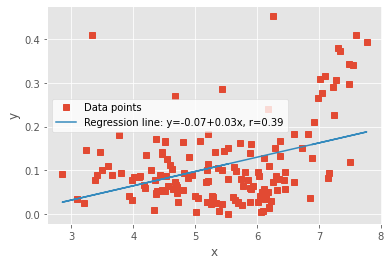

In [29]:
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

Positive correlation, i.e. higher happiness in countries with higher perceptions of corruption!

In [30]:
xy = np.array([x, y])
corr_matrix = np.corrcoef(xy).round(decimals=2)
corr_matrix

array([[1.  , 0.39],
       [0.39, 1.  ]])

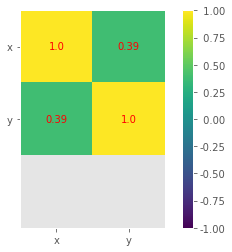

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('x', 'y'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('x', 'y'))
ax.set_ylim(2.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

**Use seaborn**

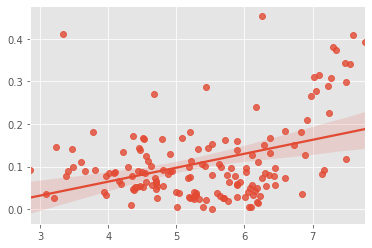

In [32]:
sb.regplot(x = x, y = y)

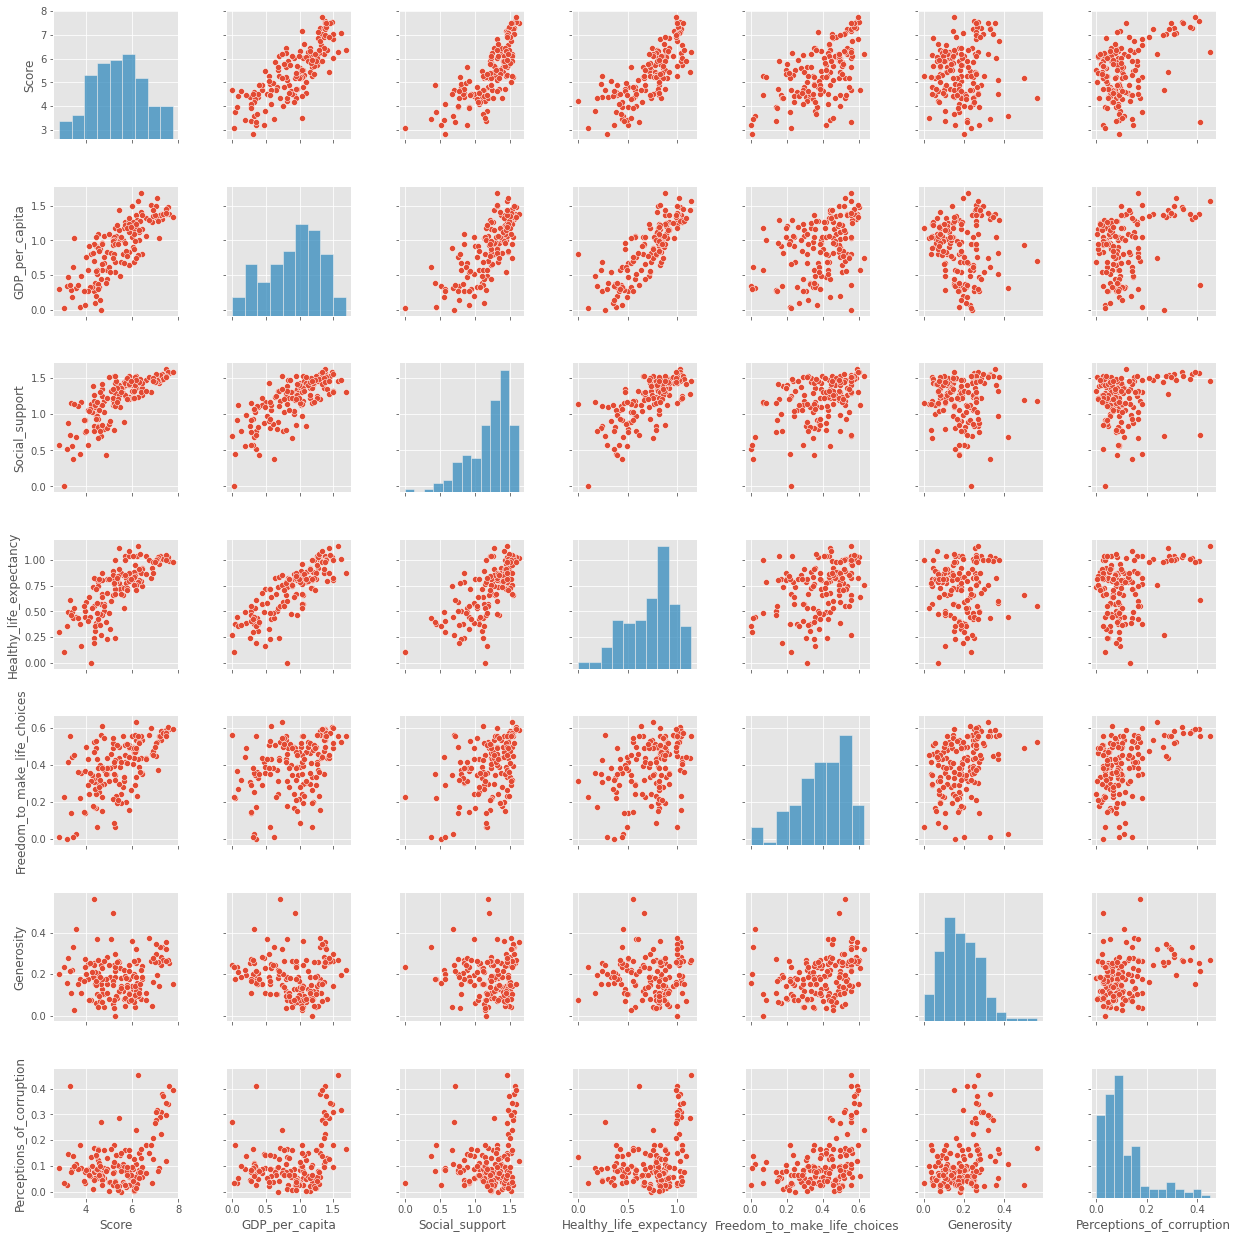

In [33]:
sb.pairplot(df, vars = ['Score', 'GDP_per_capita', 'Social_support', 'Healthy_life_expectancy',
                        'Freedom_to_make_life_choices', 'Generosity', 'Perceptions_of_corruption'])

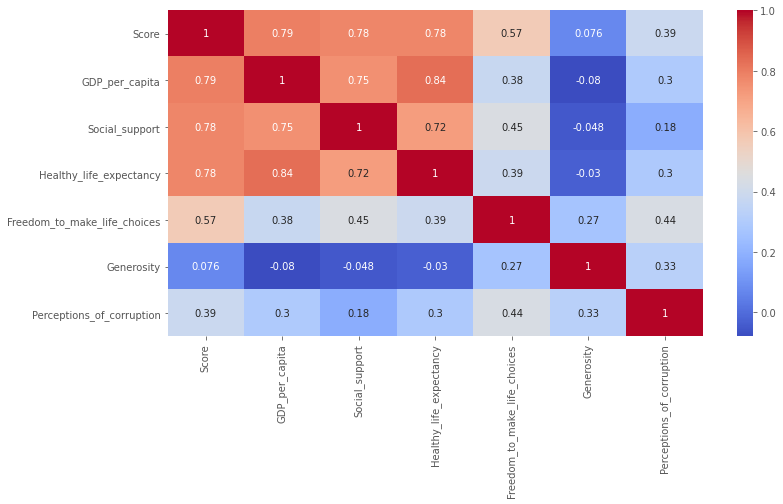

In [35]:
plt.figure(figsize=(12, 6))
sb.heatmap(data = df.loc[:,'Score':'Perceptions_of_corruption'].corr(), cmap = 'coolwarm', annot = True)

In [38]:
data = dict(
        type = 'choropleth',
        colorscale = 'Viridis',
        marker_line_width=1,
        locations = df['Country_or_region'],
        locationmode = 'country names',
        z = df['Score'],
        text = df['Country_or_region'],
        colorbar = {'title' : 'Happiness Score'},
        
      )
layout = dict(title = 'Happiness Map',
              geo = dict(projection = {'type':'mercator'}, showocean = False, showlakes = True, showrivers = True)
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)